In [47]:
import torch
import random
import torch.nn.functional as F
from torch.nn.init import kaiming_normal_
from torch.nn import (
    Sequential,
    Tanh,
    Linear,
    BatchNorm1d,
    Embedding,
    Flatten,  #checkout the flatten before use
)
import requests
import matplotlib.pyplot as plt
%matplotlib inline

In [31]:
# data_link = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
# file = requests.get(data_link)
# with open('names.txt', 'wb') as f:
#   f.write(file.content)

# words = open('names.txt', 'r').read().splitlines()

#alternative approach
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

words = open('names.txt', 'r').read().splitlines()

--2024-06-12 19:29:47--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt.1’

names.txt.1         100%[===================>] 222.80K  --.-KB/s    in 0.03s   

2024-06-12 19:29:47 (6.48 MB/s) - ‘names.txt.1’ saved [228145/228145]



In [32]:
# comment this part in the repo
word_count = len(words)
max_length = max(len(word) for word in words)
min_length = min(len(word) for word in words)

print(f"{word_count=} \n {max_length=} \n {min_length=}")

word_count=32033 
 max_length=15 
 min_length=2


## Bigram Implementation

In [33]:
# create a lookup table for strings
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}


In [36]:
block_size = 8

def build_dataset(words):
  X, Y = [], []
  for word in words:
    context = [0] * block_size
    for ch in word + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182552, 8]) torch.Size([182552])
torch.Size([22817, 8]) torch.Size([22817])
torch.Size([22777, 8]) torch.Size([22777])


In [ ]:
# DO NOT RUN

# Defining Pytorch Modules to be used
'''Linear Class'''
class Linear:
  def __init__(self, fan_in: str, fan_out: str, bias: bool=True):
    self.weight = kaiming_normal_(torch.randn(fan_in, fan_out), nonlinearity='tanh')
    #self.weight = torch.randn(fan_in, fan_out) / fan_in**0.5
    self.bias = torch.randn(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias:
      self.out = out + self.bias
    return self.out    # self.out is used because we need to call methods using the output

  def parameters(self):
    return [self.weight] + ([] if not self.bias else [self.bias])


'''Embedding Layer'''
class Embedding:
  def __init__(self, num_embeddings: int, embedding_dim: int):
    self.weight = torch.randn(num_embeddings, embedding_dim)

  def __call__(self, IX):
    self.out = self.weight[IX]  #indexing into the embedding lookup

    return self.out

  def parameters(self):
    return [self.weight]

'''Flatten'''
class Flatten:

  def __call__(self, x: torch.tensor):
     self.out = x.view(x.size(0), -1)  #notice torch.size(0) == torch.shape[0]
     return self.out

  def parameters(self):
    return []

'''Sequential'''
class Sequential:

  def __init__(self, *args):
    self.layers = [*args]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]  # if the class structure exists, triple comprehension is possible p must match last p.


'''BatchNorm1D'''
(X - mean(0(batch dimension))) / std(0, batch dimension) #broadcasting will occur with mean and var

'''LayerNorm'''
(X - mean(1(b dimension))) / std(layer dimension)    #broadcasting will occur with mean and var





In [37]:
torch.manual_seed(42)

In [38]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []


In [46]:
# model architecture

n_embed = 24
n_hidden = 200
vocab_size = len(stoi.values())
# sequential expect subclasses of nn.Module (layers built in pytorch are built by subclassing nn.Moduule like models)
model = Sequential(
    Embedding(vocab_size, n_embed), Flatten(),
    Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),

)

# for our custom sequential class
# with torch.no_grad():
#   model.layers[-2].weight *= 0.01    #making the last  output less confident

# torch.nn.Sequential is accessed directly
with torch.no_grad():
  model[-2].weight *= 0.01

print(sum(p.nelement() for p in model.parameters()))  # p is a tensor, we can do p.grad() but we'll have to do nelement() to count parameters

for p in model.parameters():
  p.requires_grad = True


# #without sequential

# layers = [
#     Embedding(vocab_size, n_embed), Flatten(),
#     Linear(n_embed * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#     Linear(n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),

# ]

# #in run script

# for layer in layers:
#   x = layer(x)
# output = x


166102


In [48]:
# actual training process
max_steps = 200000
batch_size = 32
lossi = []
for i in range(200000):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix]

  # pass xb through the model
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backprop
  for p in model.parameters():
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in model.parameters():
    p.data += -lr * p.grad
  lossi.append(loss.log10().item())
  if i % 10000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")

      0/ 200000: 3.4395
  10000/ 200000: 2.0620
  20000/ 200000: 2.1364
  30000/ 200000: 1.9383
  40000/ 200000: 2.1067
  50000/ 200000: 1.6607
  60000/ 200000: 2.0680
  70000/ 200000: 1.5567
  80000/ 200000: 1.8163
  90000/ 200000: 2.2146
 100000/ 200000: 1.8101
 110000/ 200000: 1.8675
 120000/ 200000: 1.7056
 130000/ 200000: 1.5397
 140000/ 200000: 1.7038
 150000/ 200000: 1.6532
 160000/ 200000: 1.4250
 170000/ 200000: 1.4871
 180000/ 200000: 2.0108
 190000/ 200000: 1.2696


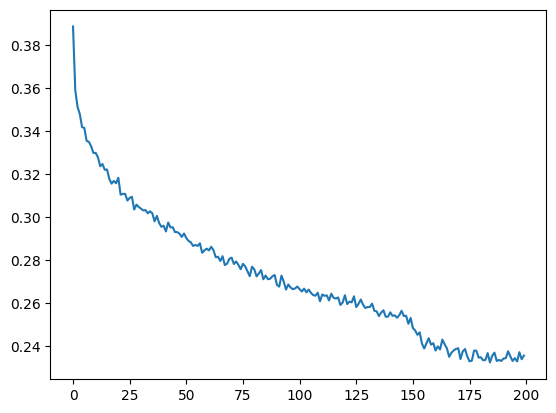

In [49]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [50]:
# set out of training mode

# #using our custom Sequential
# for layer in model.layers():
#   layer.eval() or layer.training = False

# using torch.nn.Sequential
model.eval()

print(model.training)

False


In [53]:
# evaluation on entire dataset

@torch.no_grad()   # for faster operation
def split_loss(split):
  x, y = {
      'train': (Xtr, Ytr),
      'val': (Xdev, Ydev),
      'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 1.6500
val loss: 1.9862


In [52]:
# sampling from the model
g = torch.Generator().manual_seed(1234543)
for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    # remember to preserve first dim of context
    logits = model(torch.tensor([context]))
    probs = F.softmax(logits, dim=1)


    ix = torch.multinomial(probs, num_samples=1, replacement=True).item()
    out.append(ix)
    context = context[1:] + [ix]
    if ix == 0:
      break
  print(''.join(itos[i] for i in out))



kyer.
aalaya.
silvia.
samoni.
lory.
isille.
jethmah.
amadhmarah.
himani.
marhan.
macyn.
naysy.
namita.
novalas.
azara.
trishaba.
greys.
ettis.
maryor.
quinnlee.
